In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cofactor.features import Features
from cofactor.model import LatticePredictor
from cofactor.calculator import CofactorCalculator

In [17]:
featgen = Features.from_excel('data/elemental.xlsx')
model = LatticePredictor.from_file('models/model.pkl')
data = pd.read_csv('data/lattices.csv', index_col=0)

In [30]:
def features_from_df(df, element):
    df['T0'] = df['T0 (K)'] - 273
    df['Ms'] = df['Ms (K)'] - 273
    df['x'] = to_mol_percent(df, element)
    
    inputs = {
        element: df.x.values.reshape(-1, 1),
        'Zr': 1 - df.x.values.reshape(-1, 1),
        'T': df.T0.values.reshape(-1, 1),
        'Ms': df.Ms.values.reshape(-1, 1),
    }
    X = featgen.get_features(inputs, model.features)
    
    return X

def get_cofactors(X, model):
    cofactors = []
    dV = []
    for tetr, mono in model.predict_lattice(X[model.features]):
        calc = CofactorCalculator(tetr, mono)
        cofactors.append(calc.get_cofactors())
        dV.append(calc.get_volume_change())

    return pd.concat([X, pd.DataFrame(cofactors), pd.DataFrame(dV)], axis=1)

def get_gradient(results, element):
    grad_dilute = results[[element, 'T', 'B_lambda']][:2].diff().iloc[-1]
    
    dT_dx = grad_dilute['T'] / grad_dilute[element]
    dL_dx = grad_dilute['B_lambda'] / grad_dilute[element]
    
    return dT_dx, dL_dx

def to_mol_percent(df, element):
    x = df.iloc[:, 0] / 100

    s = df.columns[0]
    num = re.findall(element + '(\d)O', s)
    if len(num) == 0:
        return x

    return x / (int(num[0]) - x)

### Design charts

In [71]:
files

['Al.csv', 'Ca.csv', 'Cr.csv', 'Gd.csv', 'La.csv', 'Ti.csv', 'Y.csv']

In [72]:
UNCERTAINTY_LAMBDA = 0.001145

ELEMENT_STR = {
    'Al': r'Al$^{3+}',
    'Ca': r'Ca$^{2+}',
    'Cr': r'Cr$^{3+}',
    'Gd': r'Gd$^{3+}',
    'La': r'La$^{3+}',
    'Ti': r'Ti$^{4+}',
    'Y': r'Y$^{3+}',
}

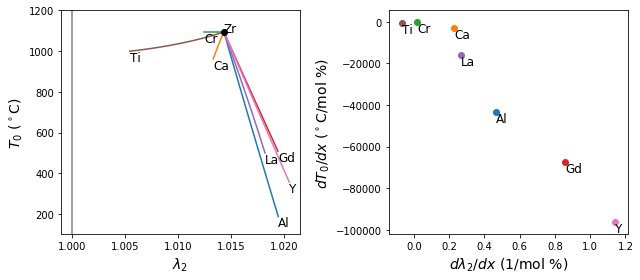

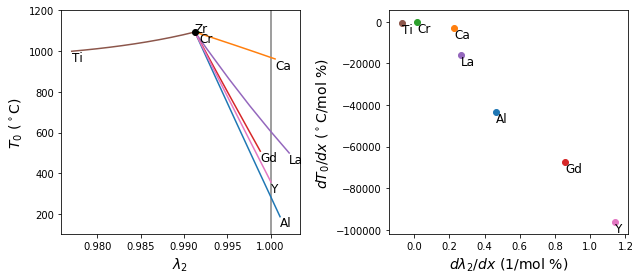

In [31]:
for corresp in ['A_lambda', 'B_lambda']:
    files = sorted(os.listdir('data/t0'))
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))

    for file in files:
        element = file.strip('.csv')
        df = pd.read_csv(os.path.join('data/t0', file))
        X = features_from_df(df, element)
        results = get_cofactors(X, model)
        results = results.sort_values(element)

        ax[0].plot(results[corresp], results['T'], label=element)
#         ax[0].fill_betweenx(
#             results['T'],
#             results[corresp] - UNCERTAINTY_LAMBDA,
#             results[corresp] + UNCERTAINTY_LAMBDA,
#             alpha=0.2
#         )
        ax[0].annotate(element, (results[corresp].values[-1], results['T'].values[-1]), fontsize=12, va='top')

        dT, dL = get_gradient(results, element)
        ax[1].scatter(dL, dT)
        ax[1].annotate(element, (dL, dT), fontsize=12, va='top')

    ax[0].scatter([results[corresp].values[0]], [results['T'].values[0]], zorder=3, color='k')
    ax[0].annotate('Zr', (results[corresp].values[0], results['T'].values[0]), fontsize=12)

    ax[0].set_xlabel(r'$\lambda_2$', fontsize=14)
    ax[0].set_ylabel(r'$T_0$ ($^\circ$C)', fontsize=14)

    ylim = (100, 1200)
    ax[0].set_ylim(ylim)
    ax[0].plot([1, 1], ylim, color='#808080', zorder=-1)

    ax[1].set_xlabel(r'$d\lambda_2/dx$ (1/mol %)', fontsize=14)
    ax[1].set_ylabel(r'$dT_0/dx$ ($^\circ$C/mol %)', fontsize=14)


    # ax.legend()
    fig.tight_layout()
    plt.show()

In [32]:
results

,T,en_p,ea,valence,rad_slater,rad_clementi,Y,Zr,Ms,A_lambda,B_lambda,C_lambda,A_dV,B_dV,C_dV
0,1094.000000,1.330000,0.426000,4.000000,1.550000,2.060000,0.000000,1.000000,944.000000,1.014314,0.991268,1.014314,1.035155,1.035155,1.035155
1,852.772584,1.329724,0.425702,3.997494,1.550627,2.060150,0.002506,0.997494,700.371700,1.016317,0.994125,1.016317,1.037993,1.037993,1.037993
2,606.668064,1.329447,0.425402,3.994975,1.551256,2.060302,0.005025,0.994975,452.024264,1.018371,0.997056,1.018371,1.040898,1.040898,1.040898
3,356.557866,1.329169,0.425101,3.992443,1.551889,2.060453,0.007557,0.992443,199.842553,1.020469,1.000052,1.020469,1.043863,1.043863,1.043863


### Elemental properties

In [73]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


def plot_props(df, element):
    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.3))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)

    x = df[element] * 100
    dV = (df['B_dV'] - 1) * 100
    p1, = host.plot(x, df['T'], color="#d62728", label="T0")
    p1_2, = host.plot(x, df['Ms'], color="#ff7f0e", label="Ms")
    p2, = par1.plot(x, df['B_lambda'], color="#2ca02c")
    p3, = par2.plot(x, dV, linestyle='--', color="#1f77b4")

#     host.set_xlim(0, 2)
#     host.set_ylim(0, 2)
#     par1.set_ylim(0, 4)
#     par2.set_ylim(1, 65)

    host.set_xlabel('%s (mol %%)' % ELEMENT_STR.get(element, element), fontsize=12)
    host.set_ylabel(r'Temperature ($^\circ$C)', fontsize=12)
    par1.set_ylabel(r'$\lambda_2$', fontsize=12)
    par2.set_ylabel(r'$\Delta V$ (%)', fontsize=12)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p1_2]

    host.legend(lines, [l.get_label() for l in lines])
    
    fig.tight_layout()
    plt.show()

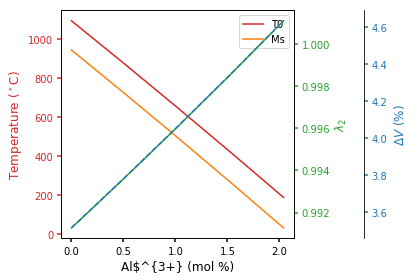

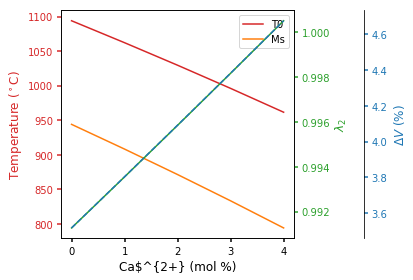

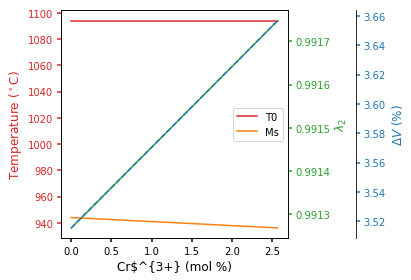

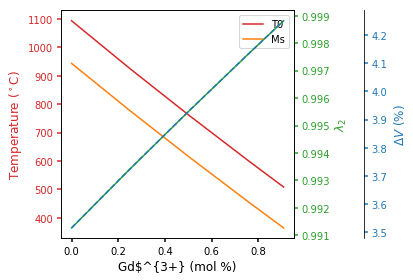

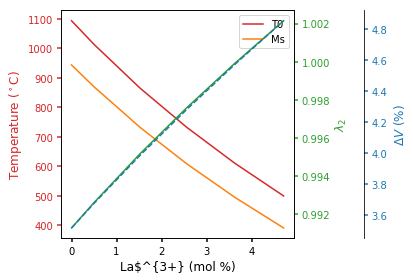

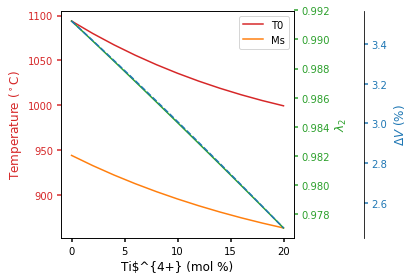

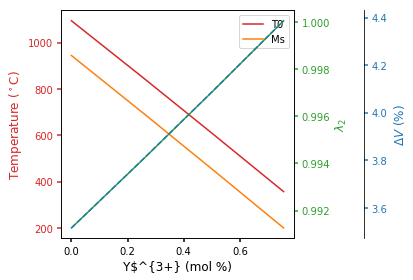

In [74]:
files = sorted(os.listdir('data/t0'))

for file in files:
    element = file.strip('.csv')
    df = pd.read_csv(os.path.join('data/t0', file))
    X = features_from_df(df, element)
    results = get_cofactors(X, model)
    results = results.sort_values(element)

    plot_props(results, element)
